In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from tune_sklearn import TuneGridSearchCV
from sklearn import preprocessing
import sys
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn import metrics
import json
import multiprocessing


params = {
    "norm":0,                   # normalised: 0 = only "abs", 1 = only "norm", 2 = norm and abs
    "weighted" : False,          # weighted_vals: whether votes should be weighted by comment score FALSE IS BETTER 0.32
    "title_prepend" : False,     # title_prepend: whether to use the title prepended or standalone dataset
    "sampling" : "up",          # sampling_vals: which type of sampling should be done
    "topics_separate": False,   # if each topic should be analysed separately
    "predict":"class",          # should we predict "class" (classification for binary) or "ratio" (regression for AHR)
    "mapping":"opposite",       # should we "clip" negative votes or map them to the "opposite"
    "ratio": 0.3,               # which most extreme AHR or YTA_ratio we want to predict 0.3, 0.2, 0.1, 0.05
    "wo_metadata": True        # wheter we should include metadata columns (e.g. post_score, account_karam, link_karma) set MANUALLY
}

FORCE_RANDOM_Y = False
FORCE_SIMPLIFY = True
DO_SHAPLY = True
SHOW_PREDICTION_DISTRIBUTION = False
FEAT_IMPORTANCE_N = 50
OUTPUT_DIR = "./output/" if not params["wo_metadata"] else "./output_wometadata/"
DATASETS_DIR = "../datasets/"
    
def get_data(normalised=1, weighted=True, title_prepend=True, topics_separate=False, wo_metadata=False):
    prepend_csv = "prepend_mf_liwc_angel_info_topic_scores_reactions_reduced_da.csv"
    standalone_csv = "standalone_liwc_mf_angel_info_topic_scores_reduced_reactions_da.csv"
    
    if title_prepend:
        df = load_wo_cols(DATASETS_DIR+prepend_csv, wo_metadata=wo_metadata)
    else:
        df = load_wo_cols(DATASETS_DIR+standalone_csv, wo_metadata=wo_metadata)
         

    if normalised < 2:
        df = df[df.columns.drop(list(df.filter(regex="_abs" if normalised == 1 else "_norm")))]
        

    keys = ["info", "yta", "nah", "esh", "nta"]
    weight = "weighted_" if weighted else ""
    values = ["reactions_"+weight+k.upper() for k in keys]
    acros = dict(zip(keys, values))
    
    dfs = []
    if topics_separate >0:
        
        topic_min = df["topic_nr"].min()
        topic_max = df["topic_nr"].max()
        #print(f"Data split by topic ({topic_min}, {topic_max})")
         
        for i in range(topic_min, topic_max+1):
            dfs.append(df.loc[df["topic_nr"]==i])
    else:
        dfs = [df]

    #print(f"Number of dataframes: {len(dfs)}")

    
    return dfs, acros

def load_wo_cols(path, remove_cols=[],verbose=False, wo_metadata=False):
    cols_to_remove = ["post_text", "Unnamed: 0", "Unnamed: 1", "Unnamed: 2", "Unnamed: 0.1", 
                      "Unnamed: 0.1.1", "liwc_post_id", "foundations_post_id", 
                      "foundations_title_post_id", "liwc_title_post_id", "post_created_utc"]+remove_cols
    metadata = ["speaker_account_comment_karma", "post_num_comments", "post_ratio", "speaker_account_age", "speaker_account_link_karma", "post_ups", "post_downs", "post_score","reactions_is_devil", "reactions_is_angel"]
    
    if wo_metadata:
        cols_to_remove = cols_to_remove+metadata
        
    removed = []
    df = pd.read_csv(path, nrows=10)
    cols_to_read = list(df.columns)
    
    if verbose:
        print(cols_to_read)
    for col in cols_to_remove:
        if col in cols_to_read:
            cols_to_read.remove(col)
            removed.append(col)
    
    print(f"Removed {removed} from {path.split('/')[-1]}")        
    df = pd.read_csv(path, usecols=cols_to_read)
    return df



def sampling(y, kind="up", indices=[], verbose=False):
    
    df_y = pd.DataFrame(data={"Y":y})
    
    if len(indices)>0:
        if verbose:
            print(f"Using {len(indices)} indices")
    else:
        indices = range(len(indices))
        

    # Get list of indices for classes that are in the indices array
    c0_idx = pd.Series(df_y.loc[df_y["Y"]==0].index.values)
    c0_idx = c0_idx[c0_idx.isin(indices)]
    c1_idx = pd.Series(df_y.loc[df_y["Y"]==1].index.values)
    c1_idx = c1_idx[c1_idx.isin(indices)]
    
    if verbose:
        print(f"    Y=0: {c0_idx.shape}")
        print(f"    Y=1: {c1_idx.shape}")

    if kind == "up":
        #upsample
        if len(c0_idx)>len(c1_idx):
            n = len(c0_idx)
            c1_idx_sampeled = c1_idx.sample(n=n, random_state = 1, replace=len(c1_idx)<n).values
            c0_idx_sampeled = c0_idx.values
            if verbose:
                print(f"Upsampling Y=1 with {n} samples")
                
        elif len(c0_idx)<len(c1_idx):
            n = len(c1_idx)
            c0_idx_sampeled = c0_idx.sample(n=n, random_state = 1, replace=len(c0_idx)<n).values
            c1_idx_sampeled = c1_idx.values
            if verbose:
                print(f"Upsampling Y=0 with {n} samples")
                
    elif kind =="down":
        #downsample
        if len(c0_idx)>len(c1_idx):
            n = len(c1_idx)
            c0_idx_sampeled = c0_idx.sample(n=n, random_state = 1, replace=len(c0_idx)<n).values
            c1_idx_sampeled = c1_idx.values
            if verbose:
                print(f"Downsampling Y=0 with {n} samples")
        elif len(c0_idx)<len(c1_idx):
            n = len(c0_idx)
            c1_idx_sampeled = c1_idx.sample(n=n, random_state = 1, replace=len(c1_idx)<n).values
            c0_idx_sampeled = c0_idx.values
            if verbose:
                print(f"Downsampling Y=1 with {n} samples")

    all_idx = np.concatenate((c0_idx_sampeled, c1_idx_sampeled), axis=0)
    
    if verbose:
        df_tmp = df_y.iloc[all_idx]
        print(f"   Y=0: {len(df_tmp.loc[df_tmp['Y']==0])}")
        print(f"   Y=1: {len(df_tmp.loc[df_tmp['Y']==1])}")
    return all_idx

def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

def opposite_jdgmt(judg):
    
    if "NTA" in judg  :
        rtn =  judg.replace("NTA","YTA")
    elif "NAH" in judg:
        rtn =  judg.replace("NAH","ESH")
    elif "YTA" in judg:
        rtn =  judg.replace("YTA","NTA")
    elif "ESH" in judg:
        rtn =  judg.replace("ESH","NAH")
    elif "INFO" in judg:
        rtn = judg
    
    return rtn+"_neg_vals"

def get_vote_counts(df, acros):
    dct = {}
    for acr in list(acros.values()):
        dct[acr] = len(df[acr].to_numpy().nonzero()[0])
    
    dct["total"] = np.sum(list(dct.values()))
    print(dct)
    
    
# mapping is either "clip", meaning negative votes are just set to 0, or "oppossite", meaning we use the mapping table in "opposite_jdgmt"
def map_negative_values(df, acros, mapping="clip"):
    
    if mapping == "opposite" or mapping =="map":
        #print("Map = opposite")    
        for k in acros.keys():
            acr = acros[k]
            #print(f"{acr} pos amount {len(df.loc[df[acr] > 0])}")
            #print(f"{acr} neg amount {len(df.loc[df[acr] < 0])}")
            
            
            if k == "info":
                continue
            
            # create temporary columns containing zeros and only negative votes for each vote type (except info)        
            df[acr+"_neg_vals"] = 0
            df.loc[df[acr] < 0, acr+"_neg_vals"] = df[acr]*-1
            df.loc[df[acr] < 0, acr] = 0
            
        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            #set negative values to 0 & add opposite judgement vote 
            df[acr] = df[acr] + df[opposite_jdgmt(acr)]
           
    elif mapping =="clip":
        #print("Map = clip")    
        for k in acros.keys():
            acr = acros[k]
            df.loc[df[acr]<0,acr]=0
        
            
    # finally set all negative info votes to 0
    #df[df[acros["info"]] < 0] = 0
    
    #print("info sum", df[acros["info"]].min())
    
    return df


def get_data_classes(df, acros, ratio=0.5, verbose=False, predict="class", judgement_weighted=True, mapping="clip"):
    if verbose:
        print(f"df original shape {df.shape}")
        
    n_rows_old = len(df)
    
    # Map negative judgements to opposing judgement
    # i.e. YTA<->NTA, ESH<->NAH
    if judgement_weighted:
        df = map_negative_values(df, acros,mapping=mapping)
    
    if predict=="class":   
        # We only look at YTA and NTA
        df["YTA_ratio"] = df[acros["yta"]]/(df[acros["info"]]+ df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])

        # drop all rows where the majority is not YTA or NTA
        df = df.loc[((df[acros["yta"]] > df[acros["info"]]) & (df[acros["yta"]] > df[acros["nah"]]) & (df[acros["yta"]] > df[acros["esh"]])) | ((df[acros["nta"]] > df[acros["info"]]) & (df[acros["nta"]] > df[acros["nah"]]) & (df["reactions_weighted_NTA"] > df[acros["esh"]]))]
        if verbose:
            print(f"Drop all rows where majority is not YTA or NTA {df.shape}")

        #drop all rows that are not "extreme" enough
        df = df.loc[(1-ratio<=df["YTA_ratio"]) | (df["YTA_ratio"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")

        #specifc classes & drop unnecesarry
        df["Y"] = np.where(df[acros["yta"]] > df[acros["nta"]], 1,  0) # YTA = Class 1, NTA = class 0
        
        #Sanity check, i.e. get results for random predition
        if FORCE_RANDOM_Y:
            df["Y"] = np.random.randint(0, 2, size=len(df["Y"]))
            print("USING RANDOM Y")
        
        if verbose:
            print(df.shape)
            
    elif predict == "ratio":
        # Y = asshole ratio(AHR) = (YTA+ESH)/(YTA+ESH+NTA+NAH)
        
        #drop posts w.o. votes
        tmp = df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]]
        tmp = tmp[tmp != 0]
        tmp = (df[acros["yta"]]+df[acros["esh"]])/tmp
        df["Y"] = tmp

        if FORCE_RANDOM_Y:
            #Sanity check, i.e. get results for random predition
            df["Y"] = np.random.randint(0, 1001, size=len(df["Y"]))/1000
            print("USING RANDOM Y")
        
        if verbose:
           print(f"Removed {n_rows_old-len(df)} rows b.c. no votes. Now {df.shape}")
        n_rows_old = len(df)
        df = df.loc[(1-ratio<=df["Y"]) | (df["Y"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")
        
    if np.min(df["Y"]) < 0 or np.max(df["Y"])>1:
        raise Exception("Y value should be in range [0,1]")
        
    # get list of all columns that contain uppercase vote acronym
    vote_acroynms = list(filter(lambda x: any([acr.upper() in x for acr in list(acros.keys())]), list(df.columns)))  
    df = df.drop(columns=vote_acroynms)
    
    cols_to_drop =  ["post_text", "post_id", "post_created_utc"] 
    for col in cols_to_drop:
        if col in list(df.columns):
            df = df.drop(columns=[col])
        
    #print(df.info(memory_usage="deep"))

    # Removing top 4 most important features leads to 0.66 f1
    if verbose:
        print(df.shape)
    
    X = df.drop(columns=["Y"])
    y = df["Y"].to_numpy()

    feat_name_lst = list(X.columns)

    # scaling
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, y, feat_name_lst     


def get_train_test_split(grid_search=False):
    dfs, acros = get_data(normalised=params["norm"], weighted=params["weighted"], title_prepend=params["title_prepend"], topics_separate=params["topics_separate"], 
                        wo_metadata=params["wo_metadata"])

    df = dfs[0]
    if len(dfs)>1:
        print("MORE THAN 1 df")

    df_cpy = df.copy()
    X, y, feat_name_lst = get_data_classes(df_cpy, ratio=params["ratio"], acros=acros, predict=params["predict"], judgement_weighted=params["weighted"],
                                    mapping=params["mapping"],verbose=False)   

    
    
    if grid_search:
        return X, y, feat_name_lst
    
    train, test = train_test_split(range(len(X)), test_size=0.33, random_state=42)
    X_train = X[train, :]
    y_train = y[train]
    X_test = X[test, :]
    y_test = y[test]

    return X_train, y_train, X_test, y_test, feat_name_lst

def get_clf_name(params, clf_type):
    clf_name = clf_type
    for k,v in params.items():
        if isinstance(v, bool) and v:
            clf_name += f"_{k}"
        else:
            clf_name += f"_{k}={v}"
    return clf_name

def print_metrics(y_test, y_pred):
    if params["predict"] == "class":
        print("class")
        # testing score
        f1_test = metrics.f1_score(y_test, y_pred, average="weighted")
        acc_test = metrics.accuracy_score(y_test, y_pred)
        #test_scores[clf_name]=f1_test
        print(f"    Accuracy: {acc_test}\n    F1: {f1_test}")

    elif params["predict"] == "ratio":
        print("ratio")
        mean_abs = metrics.mean_absolute_error(y_test, y_pred)
        mean_sqr = metrics.mean_squared_error(y_test, y_pred)
        rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
        
        print(f"    Mean absolute: {mean_abs}\n    Mean squared: {mean_sqr}\n    Root Mean Squared: {rmse}")


### 1. Setup

In [2]:
print("CLASSIFICATION\n----" if params["predict"]=="class" else "REGRESSION\n----")

xgboost = xgb.XGBClassifier(verbosity = 0, random_state=42,tree_method='gpu_hist') if params["predict"] == "class" else xgb.XGBRegressor(verbosity = 0, random_state=42,tree_method='gpu_hist')
classifiers = (xgboost, "xgboost")

print("Models:\n"+classifiers[1])
print("\nClassification params:\n"+str(json.dumps(params, indent = 4)))

REGRESSION
----
Models:
xgboost

Classification params:
{
    "norm": 0,
    "weighted": false,
    "title_prepend": false,
    "sampling": "up",
    "topics_separate": false,
    "predict": "ratio",
    "mapping": "opposite",
    "ratio": 0.5,
    "wo_metadata": true
}


### 2. Classifier hyper param search

#### 2.1 Normal execution

In [3]:
clf_name = get_clf_name(params, classifiers[1])
X_train, y_train, X_test, y_test, feat_name_lst = get_train_test_split()
_ = plt.hist(y_train, bins='auto')  
plt.show()
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
print_metrics(y_test, y_pred)

Removed [] from standalone_liwc_mf_angel_info_topic_scores_reduced_reactions_da.csv


#### 2.2 Grid seach

In [3]:
clf_name = get_clf_name(params, classifiers[1])
X, y , feat_name_lst = get_train_test_split(grid_search=True)

cores = multiprocessing.cpu_count()
tuning_params = {'nthread':[cores], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [3, 6, 8],
              'min_child_weight': [1,4, 20,100],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'lambda': [0.1, 0.5, 1],
              'n_estimators': [50,100,350,500], 
              }

grid_seach = TuneGridSearchCV(classifiers[0],
                        tuning_params,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

grid_seach.fit(X,y)

print(grid_seach.best_score_)
print(grid_seach.best_params_)


### Shap interaction & dependence

100%|===================| 83648/83766 [03:21<00:00]        

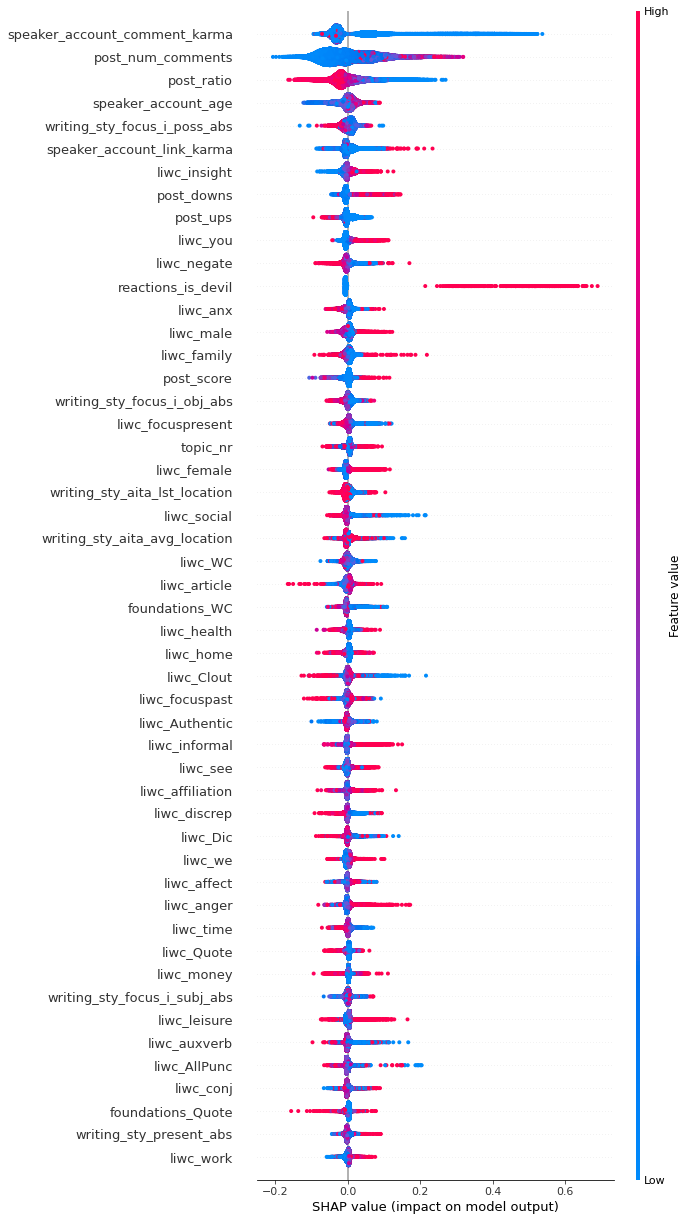

In [5]:

explainer = shap.explainers.GPUTree(xgboost, X_train)
#explainer = shap.explainers.Tree(xgboost, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feat_name_lst, max_display=50)

In [8]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
shap.dependence_plot("rank(1)", shap_values, X_train)

In [7]:
# https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a
shap_interaction = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction, X_train)

MemoryError: Unable to allocate 20.2 GiB for an array with shape (83766, 180, 180, 1) and data type float64